In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
 
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
 
drive.mount(ROOT)           # we mount the google drive at /content/drive


/content/drive
Mounted at /content/drive


## This Notebook Gave in SMR=0 SDR=2.57 and 2.45

In [2]:
!touch helpers2.py

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

from numpy import linalg as LA
from numpy.linalg import inv
from helpers2 import Reconstruct, Viz_Y,SMR,get_mixed_signal,SDR,ReconstructSoft,butter_lowpass_filter
import seaborn as sns
import warnings
import math
from tqdm import tqdm
warnings.simplefilter('ignore')

In [4]:
def eval(D,G_test,Ytest):
  Sources,Masks=Reconstruct(B=D,G=G_test,Ns=Dc.shape[1],Nm=Nm,Yabs=Ytest,p=0.5)

  print('Reconstruction Step .... Done')
  speech_est = Sources[0]
  music_est = Sources[1]

  _, speech_est =  signal.istft(speech_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  _, music_est =  signal.istft(music_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  sdr_speech = SDR(s_est=speech_est,s=test_s)
  sdr_music = SDR(s_est=music_est, s=test_m)

  print(f'Speech SDR = {sdr_speech}')
  print(f'Music SDR = {sdr_music}')

In [5]:
# Best 1-20 min

start = 1 * 60 * 44100
end = 20 * 60 * 44100 

samplerate_s, data_speech = read("/content/drive/MyDrive/Conversation.wav")
speech=data_speech[start:end,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {} ... Length : {:.2f}s ... Sample rate : {}'.format(speech.shape[0],length,samplerate_s))

start = 1 * 60 * 44100
end = 5 * 60 * 44100 
samplerate_m, data_music = read("/content/drive/MyDrive/music.wav")
music=data_music[start:end,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {} ... Length : {:.2f}s ... Sample rate : {}'.format(music.shape[0],length,samplerate_m))


Shape of the speech 50274000 ... Length : 1140.00s ... Sample rate : 44100
Shape of the music 10584000 ... Length : 240.00s ... Sample rate : 44100


In [6]:
fs = 16000

rate = samplerate_s / fs


start = 1 * 60 * 44100
end = 20 * 60 * 44100


speech_t=data_speech[start : end, 0]
music_t = data_music[start : end, 0]


speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music_t = signal.resample(music_t,int(music_t.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate

print('Shape of the test {} ... Length : {:.2f}s ... Sample rate : {}'.format(music_t.shape[0],length,samplerate))

speech = signal.resample(speech,int(speech.shape[0]/rate))
music = signal.resample(music,int(music.shape[0]/rate))


print('Downsampled rate = {}'.format(samplerate))

speech = butter_lowpass_filter(speech,5000,fs)
music = butter_lowpass_filter(music,5000,fs)

music_t = butter_lowpass_filter(music_t,5000,fs)
speech_t = butter_lowpass_filter(speech_t,5000,fs)

Shape of the test 18240000 ... Length : 1140.00s ... Sample rate : 16000
Downsampled rate = 16000


## Training STFT :


In [7]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.8 * WINDOW_SIZE
NFFT=512

f,t,Y= signal.stft(speech,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_s=np.abs(Y)
f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_m=np.abs(Y)



SMR_db = 0
mix,speech_mix,music_mix=get_mixed_signal(speech_t,music_t,SMR_db)


f,t,Ymix= signal.stft(mix,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_mix=np.abs(Ymix)

Yabs_mix[Yabs_mix==0]=0.00001
write("/MixX.wav", samplerate, mix.astype(np.int16))



SMR = 0.00


## Test STFT :

In [28]:
fs = 16000

rate = samplerate_s / fs


start = 15 * 60 * 44100
step = int(0.1 * 60 * 44100)

test_s = np.array([])
test_m = np.array([])

for i in range(1):

  test_s = np.hstack([test_s,data_speech[start+i*step:start+(i+1)*step,0]])
  test_m = np.hstack([test_m,data_music[start+i*step:start+(i+1)*step,0]])


test_s = signal.resample(test_s,int(test_s.shape[0]/rate))
test_m = signal.resample(test_m,int(test_m.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate


test_s = butter_lowpass_filter(test_s,5000,fs)
test_m = butter_lowpass_filter(test_m,5000,fs)


################################################################################
SMR_db = 5
test,speech_test,music_test=get_mixed_signal(test_s,test_m,SMR_db)


f,t,Ytest= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_test=np.abs(Ytest)

Yabs_test[Yabs_test==0]=0.00001


SMR = 5.00


# Train First NMF on Clean Speech :

In [9]:
def softmax(x):

  e_x = np.exp(x)
  return e_x / e_x.sum(axis=0)

In [10]:
Nc = 8 #8
Nm = 8

model = NMF(n_components=Nc, init='random',alpha=0.0,beta_loss='frobenius',solver="mu",max_iter=50, random_state=7)
model.fit(np.transpose(Yabs_s))
Dc = np.transpose(model.components_)
scaler = MinMaxScaler()
Dc = scaler.fit_transform(Dc)


# Train NMF on Noisy Speech :

In [11]:
def nmf(X, Dc, Nn, lamb=0.1, maxit=100):

    Nc = Dc.shape[1]
    H = np.random.rand(Nc+Nn, X.shape[1])

    Dn = np.random.rand(X. shape[0], Nn)
    print(f"Shape of Dc {Dc.shape} Shape of Dn {Dn.shape}")
    D = np.hstack([Dc,Dn])
    Dnorm = D / np.sum(D**2, axis=0)**(.5)

    print(f'Dnorm shape {Dnorm.shape} and X shape {X.shape} and H shape {H.shape}')
    hist=[]
    for i in range(maxit):
        H = H * (np.matmul(Dnorm.T, X)) / (np.matmul(np.matmul(Dnorm.T, Dnorm), H) + lamb)
        D[:,Dc.shape[1]:] = (Dnorm * (np.matmul(X, H.T) + Dnorm * (np.matmul(np.ones((X.shape[0], X.shape[0])), np.matmul(Dnorm, np.matmul(H, H.T)) * Dnorm))) / (np.matmul(Dnorm, np.matmul(H, H.T)) + Dnorm * (np.matmul(np.ones((X.shape[0], X.shape[0])), np.matmul(X, H.T) * Dnorm))))[:,Dc.shape[1]:]
        Dnorm = D / np.sum(D**2, axis=0)**(.5)
        hist.append(LA.norm(X-np.matmul(Dnorm,H)))
    #Dnorm[:,Dc.shape[1]:] = softmax(Dnorm[:,Dc.shape[1]:])
    return Dnorm, H,hist

In [12]:
D,H,hist = nmf(Yabs_mix,Dc,Nm)

scaler = MinMaxScaler()
D =  scaler.fit_transform(D)


Shape of Dc (257, 8) Shape of Dn (257, 8)
Dnorm shape (257, 16) and X shape (257, 190001) and H shape (16, 190001)


# Test NMF :

In [29]:
model_test = NMF(n_components=Nc+Nm, init='nndsvd',alpha=0.1,beta_loss='frobenius',solver="mu",max_iter=200, random_state=7)
model_test.fit(np.transpose(Yabs_test))
    
model_test.components_= np.transpose(D)
G_test=np.transpose(model_test.transform(np.transpose(Yabs_test)))

In [30]:
from tqdm import tqdm



def soft(z,a,l=0.02):
  h = np.maximum(np.abs(z)-5,np.zeros(z.shape[0]))
  return h
  
def warm_start_ISTA(x,W,n_components,a,K,l=0.02):

  np.random.seed(seed=7)
  h = np.random.rand(W.shape[1] , x.shape[1])
  T = x.shape[1]

  for t_ in tqdm(range(1,T)):
    h[:,t_] = h[:,t_-1]

    for _ in range(1,K):
      z = (np.identity(n_components) - (1/a)*(np.transpose(W)@W))@h[:,t_] + \
          (1/a)*np.transpose(W)@x[:,t_]

      h[:,t_] = soft(z,a,l)
  return h 

In [31]:
h_ws = warm_start_ISTA(Yabs_test,D,16,
                    400,
                    5)


100%|██████████| 1000/1000 [00:00<00:00, 3547.10it/s]


In [32]:
h_ws[h_ws == 0] = 0.0001

In [33]:
eval(D,G_test,Ytest) ,eval(D,h_ws,Ytest)

Reconstruction Step .... Done
Speech SDR = 5.121826872724419
Music SDR = 0.8193960391070122
Reconstruction Step .... Done
Speech SDR = 5.481261430480854
Music SDR = 0.6680353657615469


(None, None)

In [34]:
eval(D,G_test,Ytest) ,eval(D,h_ws,Ytest)

Reconstruction Step .... Done
Speech SDR = 5.121826872724419
Music SDR = 0.8193960391070122
Reconstruction Step .... Done
Speech SDR = 5.481261430480854
Music SDR = 0.6680353657615469


(None, None)

# Unfolded ISTA

In [35]:
import torch

In [36]:
Sources,Masks=Reconstruct(B=D,G=G_test,Ns=Dc.shape[1],Nm=Nm,Yabs=Ytest,p=0.5)
M = Masks[0]
f,t,Y= signal.stft(test_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Y_clean=np.abs(Y)
Y_clean[Y_clean==0]=0.00001


In [37]:
X = Yabs_test
X_cmplx = Ytest
W = D
alpha = 100
K = 3
lambd = 0.01
torch.autograd.set_detect_anomaly(False)


In [119]:
def speech_mask(B,G,Ns,p):
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerator = torch.pow(torch.matmul(B1,G1),p)

    denominator = torch.pow(torch.matmul(B1,G1),p)+torch.pow(torch.matmul(B2,G2),p)
  

    mask_speech = numerator/(denominator+0.00001)

    
    return mask_speech


def sigmoid(x):
  return torch.nn.Sigmoid()(x)

def soft(z,a,l=0.02):
  h = np.maximum(np.abs(z)-0.5,np.zeros(z.shape[0]))
  return h


def error(X,M,Y):

  return torch.nn.MSELoss()(Y,M*X) 

def Unfolded_ISTA(X, W, alpha, K,m,lambd,epochs,learning_rate):
  loss_e = 0
  epoch_loss = []
  torch.manual_seed(7)
  X = torch.from_numpy(X).float()
  W = torch.from_numpy(W).float()
  W = torch.tile(W, (K,1,1))
  alpha_list = torch.tile(torch.tensor([1]).float(),(K,))
  H = torch.rand(W.shape[2],X.shape[1])
  H = torch.tile(H, (K,1,1))
  H_clone = H.clone()
  Y = torch.from_numpy(Y_clean).float()
  W1 = W[0]
  W2 = W[1]
  W3 = W[2]
 # W1.requires_grad = True
  #W2.requires_grad = True
  W3.requires_grad = True
  H_e = H[0]
  H_e.requires_grad = True
  params =   [W3] + [H_e]
  sgd = torch.optim.SGD(params,lr=learning_rate)
  for e in range(epochs):
    for t in tqdm(np.arange(1,X.shape[1]),position=0, leave=True):

      sgd.zero_grad()      


          #h0_ = unfolded_cell(W1,H,alpha_list,0,t)
        # h1_k = unfolded_cell(W2,h0_,alpha_list,1,t)
        # h2_k  = unfolded_cell(W3,h1_k.float(),alpha_list,2,t)

      mask = speech_mask(sigmoid(W3),sigmoid(H_e),8,m)
      #print(mask)
      loss = error(X[:,t],mask[:,t],Y[:,t])
      #print("\n",loss)

      loss.backward()

      sgd.step()
    print(f'Epoch {e} ... Loss = {loss.item()}')
  return (torch.nn.Sigmoid()(W3)).detach().numpy(), sigmoid(H_e).detach().numpy()


In [130]:
d_new ,s = Unfolded_ISTA(X, W, 400,3,0.5, lambd,epochs=20,learning_rate= 0.01)

  1%|          | 12/1000 [00:00<00:08, 115.05it/s]

Epoch 0 ... Loss = 163.49977111816406


  1%|          | 12/1000 [00:00<00:08, 112.79it/s]

Epoch 1 ... Loss = 153.4048309326172


  1%|          | 12/1000 [00:00<00:08, 117.96it/s]

Epoch 2 ... Loss = 155.67825317382812


  1%|▏         | 13/1000 [00:00<00:07, 123.72it/s]

Epoch 3 ... Loss = 160.64013671875


  1%|          | 12/1000 [00:00<00:08, 112.64it/s]

Epoch 4 ... Loss = 165.35545349121094


  1%|▏         | 13/1000 [00:00<00:07, 123.38it/s]

Epoch 5 ... Loss = 169.61277770996094


  1%|▏         | 13/1000 [00:00<00:07, 129.00it/s]

Epoch 6 ... Loss = 172.3710479736328


  1%|▏         | 13/1000 [00:00<00:07, 123.83it/s]

Epoch 7 ... Loss = 173.6717529296875


  1%|          | 12/1000 [00:00<00:08, 118.36it/s]

Epoch 8 ... Loss = 174.5437469482422


  1%|▏         | 13/1000 [00:00<00:08, 122.17it/s]

Epoch 9 ... Loss = 174.77940368652344


  1%|          | 12/1000 [00:00<00:08, 119.31it/s]

Epoch 10 ... Loss = 174.2681121826172


  1%|▏         | 13/1000 [00:00<00:07, 125.01it/s]

Epoch 11 ... Loss = 172.11480712890625


  1%|          | 12/1000 [00:00<00:08, 113.67it/s]

Epoch 12 ... Loss = 168.07315063476562


  1%|▏         | 13/1000 [00:00<00:08, 120.23it/s]

Epoch 13 ... Loss = 165.35714721679688


  1%|          | 12/1000 [00:00<00:08, 117.62it/s]

Epoch 14 ... Loss = 162.67347717285156


  1%|          | 12/1000 [00:00<00:08, 119.13it/s]

Epoch 15 ... Loss = 159.9063262939453


  1%|▏         | 13/1000 [00:00<00:07, 124.70it/s]

Epoch 16 ... Loss = 157.1003875732422


  1%|          | 12/1000 [00:00<00:08, 116.63it/s]

Epoch 17 ... Loss = 153.998046875


  1%|          | 12/1000 [00:00<00:08, 117.68it/s]

Epoch 18 ... Loss = 150.412353515625


100%|██████████| 1000/1000 [00:08<00:00, 118.89it/s]

Epoch 19 ... Loss = 146.39210510253906


In [131]:
d_new[d_new == 0] = 0.000001

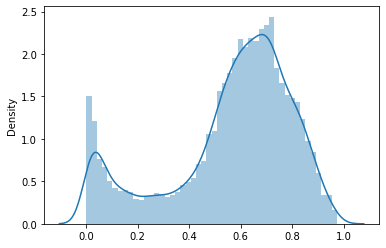

In [134]:
sns.distplot(s)

In [132]:
print("SDR Evaluation using MU \n")
eval(D,G_test,Ytest) ## mu 
print("\n")
print("SDR Evaluation using Warm Start ISTA \n")

eval(D,h_ws,Ytest)  ## warm start ISTA
print("\n")

print("SDR Evaluation using SGD on W and H \n")

eval(d_new,s,Ytest) ## DU ISTA

SDR Evaluation using MU 

Reconstruction Step .... Done
Speech SDR = 5.121826872724419
Music SDR = 0.8193960391070122


SDR Evaluation using Warm Start ISTA 

Reconstruction Step .... Done
Speech SDR = 5.481261430480854
Music SDR = 0.6680353657615469


SDR Evaluation using SGD on W and H 

Reconstruction Step .... Done
Speech SDR = 7.544101910637524
Music SDR = 1.3718635050900332


In [107]:
eval(d_new,G_test,Ytest)

Reconstruction Step .... Done
Speech SDR = 3.88776650811474
Music SDR = 0.2579344180670355


In [105]:
s.shape, d_new.shape

((16, 190001), (257, 16))

In [89]:
eval(d_new,G_test,Ytest) ## DU ISTA

Reconstruction Step .... Done
Speech SDR = 6.355166719975738
Music SDR = 0.8139672650248776


In [139]:
print("SDR Evaluation using MU \n")
eval(D,G_test,Ytest) ## mu 
print("\n")
print("SDR Evaluation using Warm Start ISTA \n")

eval(D,h_ws,Ytest)  ## warm start ISTA
print("\n")

print("SDR Evaluation using Unfolded ISTA \n")

eval(d_new,s[0],Ytest) ## DU ISTA

SDR Evaluation using MU 

Reconstruction Step .... Done
Speech SDR = 5.244604236740347
Music SDR = 0.8541149564844507


SDR Evaluation using Warm Start ISTA 

Reconstruction Step .... Done
Speech SDR = 5.752297919743787
Music SDR = 0.7212212823140547


SDR Evaluation using Unfolded ISTA 

Reconstruction Step .... Done
Speech SDR = 5.016324300365502
Music SDR = 0.4592417071328905
